In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb



# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


* 平均誤差率：大規模実行時の関数コール回数との比較
* MAPE：トレーニングデータとの比較

<Figure size 288x216 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均誤差率(%)')

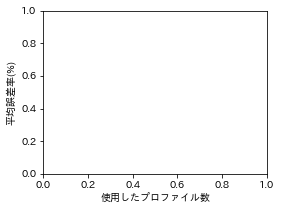

In [2]:
plt.figure(figsize=(4, 3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [3]:
# pd.get_option("display.max_columns")
# pd.get_option("display.max_rows")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [4]:
# benchmarksからbt, spを除外する
benchmarks = [benchmark for benchmark in benchmarks if benchmark !=
              'bt' and benchmark != 'sp']

In [5]:
dictTmp = returnDictForPlotPerNumOfUsedData(Benchmark=benchmarks, fix="Class", benchmarkClass=[
    "A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C")

In [6]:
pd.options.display.float_format = '{:.4g}'.format

tmpDF = pd.DataFrame()
for benchmark in benchmarks:
    listToLearn = [1, 2, 4, 8, 16, 32, 64, 128]
    listToPredict = [256]
    benchmark_x = dictTmp[benchmark]["x"]
    benchmark_y = dictTmp[benchmark]["y"]
    index = benchmark_x.index(len(listToLearn))
    MAPE = benchmark_y[index]
    relativeCost = returnRelativeCost(benchmark=benchmark, variablesToLearn=listToLearn,
                                      variablesToPredict=listToPredict, fixedClassOrProcess="Class", fixed="C")
    dictRowData = {"ベンチマーク名": benchmark.upper(), "平均絶対誤差率[％]": MAPE, "相対コスト[％]": relativeCost}
    iDF = pd.DataFrame.from_dict(dictRowData, orient='index').T
    tmpDF = tmpDF.append(iDF)
tmpDFMean = tmpDF.mean()
type(tmpDFMean)
print(tmpDF.to_latex(index=False))

pandas.core.series.Series

\begin{tabular}{lll}
\toprule
ベンチマーク名 & 平均絶対誤差率[％] & 相対コスト[％] \\
\midrule
     CG &      7.984 &    713.8 \\
     EP &          0 &    858.2 \\
     FT &  0.0004566 &    535.8 \\
     IS &  9.382e-07 &    449.2 \\
     LU &      40.65 &    499.4 \\
     MG &      1.061 &    444.7 \\
\bottomrule
\end{tabular}



<Figure size 360x360 with 0 Axes>

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

Text(0.5, 0, '使用したプロファイル数')

Text(0, 0.5, '平均絶対誤差率[％]')

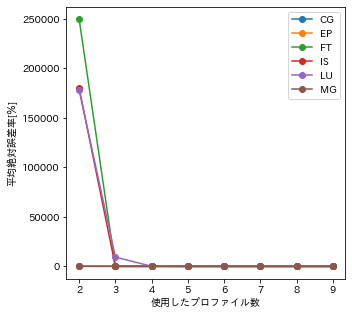

In [7]:
# dictTmp

plt.figure(figsize=(5, 5))
for benchmark in list(dictTmp.keys()):
    x = dictTmp[benchmark]["x"]
    y = dictTmp[benchmark]["y"]
    plt.plot(x, y, marker='o', label=benchmark.upper())
    plt.legend()
    plt.xlabel("使用したプロファイル数")
    plt.ylabel("平均絶対誤差率[％]")

In [8]:
# 実際にプロットする


# print(f"fix={fix}, benchmarkClasses={benchmarkClasses}, fixedProcess={fixedProcess}, Processes={processes}, FixedBenchmarkClass={fixedBenchmarkClass}")
# print(f"targetNumOfProcess={targetNumOfProcess}, targetProblemSize={fixedBenchmarkClass}, fix={fix}")

# DF = returnRawDFperBenchmark(Benchmark="mg", fix="Process", benchmarkClass=["A", "B", "C", "D"], Processes=[
#                              1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="B", FixedProcess=64)
# DF.dropna(how='any')
# DF